# 4-Introduction to D-Wave Ocean SDK

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/en/004-DWaveOceanSDK.ipynb)

D-Wave Ocean SDK (Ocean) is a collection of software that uses D-Wave Machines. It is easy to use various features from Python.

Github: https://github.com/dwavesystems/dwave-ocean-sdk  
Document: https://docs.ocean.dwavesys.com/en/latest/

To install Ocean, use pip as described in the link above, or clone the github repository.

In [ ]:
!pip install dwave-ocean-sdk

In [ ]:
!git clone https://github.com/dwavesystems/dwave-ocean-sdk.git
!cd dwave-ocean-sdk
!python setup.py install

In this section, we will discuss the following through the number division problem.

- How to make QUBO and Ising models
- How to use Ocean
- Optimization for different annealing parameters

## Formulation

There are two formats tha can be run on D-Wave machine: Ising model and QUBO. We won't got into the details here, will describe the minimum requirements for using Ocean.

### QUBO and Ising model

#### QUBO

In the case of QUBO, we consider the following Hamiltonian for binary variable $q_{i} \in \{0, 1\}$.

$$
H\left(\left\{q_{i}\right\}\right)= \sum_{i} Q_{i i} q_{i} + \sum_{i>j} Q_{i j} q_{i} q_{j}
$$

In solving QUBO, the classical computer calculates $Q_{ii}$ and $Q_{i j}$ in the above equation. The next step is to run on D-Wave machine.

#### Ising model

In the case of Ising model, we consider the following Hamiltonian for spin variable $\sigma_{i} \in \{1, -1\}$.

$$
H\left(\left\{\sigma_{i}\right\}\right)=\sum_{i} h_{i} \sigma_{i} + \sum_{i>j} J_{i j} \sigma_{i} \sigma_{j}
$$

In solving Ising model, the classical computer calculates $h_{i}$と$J_{i j}$ in the above equation. The next step is to run on D-Wave machine.

#### Reciprocal conversion

QUBO and Ising model canbe converted to each other by the conversion formula $q_{i} = (\sigma_{i} + 1) / 2$. It doesn't matter which way you formulate the Hamiltonian, so we can choose the one that is easier to consider from the subject matter. However, it should be noted that the D-Wave machine may behave differently for two different forms of the same problem.

### Number division problem

We consider dividing a fiven set of integers into two groups. The problem of dividing each group so that the sum of each group is the same is called a number division problem.

For example, we divide the following set of intergers $C$ into two groups.

In [2]:
# set integers C
C = [2, 10, 3, 8, 5, 7, 9, 5, 3, 2]
N = len(C)

In this case, There are 23 optimal solutions where the difference between the sum of the two is zero. There are multiple states in which the energy, called the difference in sums, is the same value, but the solutions are different. These states are called "degenerate" in physical terms.
For example, a optimal solution is $\{2,5,3,10,7\}, \{2,5,3,9,8\}$ (both of the sum of two is 27).

#### QUBO 

We will make the formulation with the goal of making the difference between the sum of the two groups equal to zero.

(Sum of the numbers belonging to group A) - (Sum of the numbers belonging to group B) = 0

We need binary variables $q_{i}$. We define $q_{i} = 0$ if the $i$th number belongs to group A and $q_{i} = 1$ if it belongs to group B.

Then the sum of group A is $\sum_{i=1}^{N}c_{i}q_{i}$ and the sum of group B is $\sum_{i=1}^{N}c_{i}(1 - q_{i})$, so we obtain

$$\sum_{i=1}^{N} c_{i} q_{i}-\sum_{i=1}^{N} c_{i}\left(1-q_{i}\right)=0$$

Since we want to solver the problem in that this equality holds, this must represent a `constraint`.

We use the fine method as a way of expressiong such an equality constraint.

> (the fine method)
> Let $f(x)$ be the cost (objective function) to be minimized and $g(x)=0$ for the constraint. Solving the optimization problem by adding the following terms usig the hyperparameter $\lambda$ to solve the optimization problem is called a fine method.
> $$\min_{x} \left\{ f(x) + \lambda g(x)^2\right\}$$

Therefore, QUBO for number division problem is as follows.

$$
H\left(\left\{q_{i}\right\}\right)=\left(\sum_{i=1}^{N} c_{i} q_{i}-\sum_{i=1}^{N} c_{i}\left(1-q_{i}\right)\right)^{2}
$$

In order to perform the calculation on the D-Wave machine, we need to find the value of $Q_{i j}$. We expand and organize $H\left(\left\{\sigma_{i}\right\}\right)$.

$$
H\left(\left\{q_{i}\right\}\right)=\left(2\sum_{i=1}^{N} c_{i} q_{i} - \sum_{i=1}^{N} c_{i} \right)^{2} =4 \sum_{i=1}^{N} c_{i} \left( c_{i} - \sum_{j=1}^{N} c_{j}\right) q_{i}+8 \sum_{i=1}^{N} \sum_{j=i+1}^{N} c_{i} c_{j} q_{i} q_{j}+\left(\sum_{i=1}^{N} c_{i}\right)^{2}
$$

Therefore, we obtain

$$Q_{i i} = 4 c_{i} \left( c_{i} - \sum_{j=1}^{N} c_{j}\right)$$
$$Q_{i j} = 8 c_{i} c_{j}$$

The last term is a constant that does not depends on $\{ q_i\}$. We can ignore this term in looking for combinations of $\{ q_i\}$ that minimize $H{(\{q_i\})}$.

In [6]:
# set the above Q_{ii} & Q_{ij} as a dictionary type such as {(i, j): Q_{ij}}
Q = {}
for i in range(N):
    Q[i, i] = 4 * C[i] * (C[i] - sum(C))
    for j in range(i + 1, N):
        Q[i, j] = 8 * C[i] * C[j]

In order to under stand target issues such as degree of coupling and coefficient ratios, we visualize QUBO.

In [7]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def show_qubo(qubo, cmap=cm.GnBu, save_path=None):
    n_qubo = max(sorted(qubo.keys())[-1][0], sorted(qubo.keys(), key=lambda x: x[1])[-1][1]) + 1

    np_qubo = np.zeros((n_qubo, n_qubo))
    for (pos_x, pos_y), coeff in qubo.items():
        np_qubo[pos_x][pos_y] = coeff

    plt.imshow(np_qubo, cmap=cmap)
    plt.colorbar()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

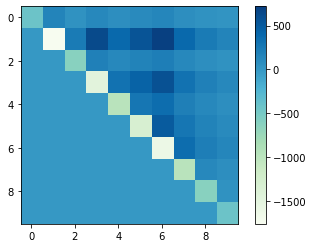

In [9]:
show_qubo(Q)

The diagonal component represents $Q_{ii}$ and the non-diagonal component represents $Q_{ij}$. It turns out that the number division problem is and all-coupling problem, where there is an interaction between all the qubits.

#### Ising model

From the formula for Ising model and teh QUBO interconversion, the number division problem can be expressed in the ising model in the following concise formula.


$$
H\left(\left\{\sigma_{i}\right\}\right) = \left(\sum_{i} c_{i} \sigma_{i}\right)^2
$$

Same as QUBO, In order to perform the calculation on the D-Wave machine, we need to find the value of $h_i, J_{ij}$. Note that $\sigma_i^2 = 1$, we expand $H\left(\left{\sigma_{i}\right\}\right)$.

$$
H\left(\left\{\sigma_{i}\right\}\right) = \sum_{i} c_{i}^2 \sigma_{i}^2 + 2 \sum_{i < j} c_{i} c_{j} \sigma_{i} \sigma_{j} = \sum_{i} c_{i}^2 + 2 \sum_{i < j} c_{i} c_{j} \sigma_{i} \sigma_{j}
$$

Therefore, we obtain

$$h_{i} = 0$$

$$J_{i j} = 2 c_{i} c_{j}$$

As with the discussion in QUBO, we ignore the constant term.

In [10]:
# set h_i & J_ij
h = {}
J = {}
for i in range(N):
    h[i] = 0
    for j in range(i + 1, N):
        J[i, j] = 2 * C[i] * C[j]

Ocean's basic library, dimod `.BinaryQuadraticModel()` allows Ising model and QUBO's interconversion.

- .BinaryQuadraticModel(linear, quadratic, offset, vartype)
    * linear: dict, h_i(or Q_{ii})
    * quadratic: dict, J_ij(or Q_{ij})
    * offset: number, Energy offset in conversion
    * vartype: set 'SPIN' if use ising model or 'BINARY' if use QUBO

In [14]:
import dimod

In [15]:
# convert from ising model to QUBO
model = dimod.BinaryQuadraticModel(h, J, 0.0, vartype='SPIN')
qubo, offset = model.to_qubo()

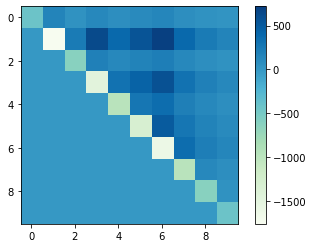

In [16]:
show_qubo(qubo)

We have expanded the constructed Hamiltonian to find the coefficient matrices such as $Q_{i i}, Q_{i j}$ and $h_{i}, J_{i j}$. However, When dealing with more complex Hamiltonian, manual calculations are more complicated and may result in errors. Therefore, we can use PyQUBO, domain-specific language developed by Recruit Communications and create QUBO and ising models without having to expand Hamiltonian. For more details of PyQUBO, see also documents below.

* Github: https://github.com/recruit-communications/pyqubo  
* Document: https://pyqubo.readthedocs.io/en/latest/
* OpenJijTutorial: https://github.com/OpenJij/OpenJijTutorial/blob/master/3-PyQUBO_2_OpenJij.ipynb  
* Qiita: https://qiita.com/ynntech/items/fcfe7caf49f6a8eb3c53

## Optimization on D-Wave machine

Let us consider optimizing this problem using D-Wave machine. In this tutorial, we show (1). solving simply, (2). solving by varying the number of readings, (3). solving by changing annealing time.


### Solve Ising model

We use D-Wave machin sampler `DWaveSampler`, and use `EmbeddingComposite` for Embedding the problem in the chimeragraph of D-Wave machine.

In [90]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [91]:
# set the connection information as an option
endpoint = 'https://cloud.dwavesys.com/sapi'
token = '##########'
solver = 'DW_2000Q_VFYC_5'

# use DWaveSampler
dw = DWaveSampler(endpoint=endpoint, token=token, solver=solver)
# embed to Chimera graph
sampler = EmbeddingComposite(dw)

In [107]:
# in the case of ising model, use the following
response = sampler.sample_ising(h, J, num_reads=100)

# in the case of QUBO, use the following
# response = sampler.sample_qubo(Q, num_reads=100)

Let us check result. We can see states of solution, energy, frequence of occurrence, and percentage of broken chain on D-Wave machine with `.record`.

In [108]:
response.record

rec.array([([ 1, -1,  1,  1,  1,  1, -1,  1,  1, -1], -226., 1, 0.8),
           ([-1,  1, -1,  1,  1, -1,  1, -1,  1,  1],   30., 2, 0.8),
           ([-1,  1, -1,  1, -1, -1,  1, -1,  1,  1], -270., 1, 0.8),
           ([-1,  1, -1,  1, -1, -1,  1, -1,  1,  1], -270., 2, 0.8),
           ([-1,  1, -1,  1,  1, -1,  1, -1, -1,  1], -174., 1, 0.8),
           ([ 1, -1,  1, -1, -1,  1, -1,  1,  1, -1], -174., 1, 0.8),
           ([-1,  1, -1,  1,  1, -1,  1, -1,  1,  1],   30., 2, 0.8),
           ([ 1, -1,  1, -1, -1,  1, -1,  1,  1, -1], -174., 1, 0.8),
           ([ 1, -1,  1, -1,  1,  1, -1,  1, -1, -1], -270., 1, 0.8),
           ([ 1, -1,  1, -1, -1,  1, -1,  1,  1, -1], -174., 1, 0.8),
           ([-1,  1,  1,  1, -1, -1,  1, -1,  1,  1], -114., 1, 0.8),
           ([-1,  1,  1,  1,  1, -1,  1, -1, -1,  1],   30., 1, 0.8),
           ([ 1, -1,  1, -1,  1,  1, -1,  1, -1, -1], -270., 1, 0.8),
           ([-1,  1, -1,  1, -1, -1,  1, -1,  1,  1], -270., 2, 0.8),
           ([-1,  1,

We find out how much of this includes the optimal solution. In order to detect optimal solurion, here we find the energy value of each solution.

In [109]:
def calcurate_energy(solution, vartype='BINARY'):
    if vartype == 'BINARY':
        ene = sum(C) ** 2  # offset
        for i in range(N):
            ene += Q[i, i] * solution[i]
            for j in range(i + 1, N):
                ene += Q[i, j] * solution[i] * solution[j]
    elif vartype == 'SPIN':
        ene = sum(C[i] ** 2 for i in range(N))
        for i in range(N):
            for j in range(i + 1, N):
                ene += J[i, j] * solution[i] * solution[j]
    else:
        raise ValueError("vartype mast be 'BINARY' or 'SPIN'.")

    return ene

In [110]:
# count the number of optimal solution
num_optimal_sol = 0
optimal_sol = []
twenty_sol = []
for state in response.record:
    # 0th contains a list of state, 2nd contains the number of occurrences in .record
    solution = state[0]
    num_oc = state[2]
    # compute energy
    energy = calcurate_energy(solution, vartype='SPIN')
    # count up the times when the energy is zero
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)
    # preserve a result of 20 µs (we use later)
    twenty_sol.append(solution)

In [111]:
num_optimal_sol

3

We obtain three optimal solutions including duplicates. The two groups are as follows.

In [113]:
for solution in optimal_sol:
    group_A = [C[i] for i, s in enumerate(solution) if s==1]
    group_B = [C[i] for i, s in enumerate(solution) if s==-1]
    print(solution)
    print('Group A: ', group_A, ', Sum = ', sum(group_A))
    print('Group B: ', group_B, ', Sum = ', sum(group_B))

[ 1 -1 -1  1  1  1 -1  1 -1 -1]
Group A:  [2, 8, 5, 7, 5] , Sum =  27
Group B:  [10, 3, 9, 3, 2] , Sum =  27
[-1  1  1 -1 -1 -1  1 -1  1  1]
Group A:  [10, 3, 9, 3, 2] , Sum =  27
Group B:  [2, 8, 5, 7, 5] , Sum =  27
[ 1 -1 -1  1  1  1 -1  1 -1 -1]
Group A:  [2, 8, 5, 7, 5] , Sum =  27
Group B:  [10, 3, 9, 3, 2] , Sum =  27


We can see that the sum of the two groups is equal in these cases.
Also, result that return from D-Wave machine has many information including solution. For more details, see the documents [SampleSet](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampleset.html#dimod.SampleSet)

`data_vectors`  has a list of energy, number of state appearances and percentage of broken chain on D-Wave machine only.

In [114]:
response.data_vectors

{'energy': array([-226.,   30., -270., -270., -174., -174.,   30., -174., -270.,
        -174., -114.,   30., -270., -270., -270., -174., -114., -334.,
          30., -270., -114.,  206., -114., -366., -366.,   30., -354.,
         306., -366.,   30.,   30., -306., -270., -354.,   30., -270.,
        -366.,   30., -114., -114., -354., -334.,   30., -306.,   30.,
        -354., -354., -366., -306., -366., -354., -270.,   30., -354.,
         306., -334., -366., -366., -370., -366., -354., -366., -270.,
        -370., -306., -370., -306., -366., -334.,   30., -334., -270.]),
 'num_occurrences': array([1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 1, 2,
        2, 1, 1, 3, 1, 1, 1, 3, 1, 4, 1, 2, 2, 1, 4, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 'chain_break_fraction': array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
        0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0

`info` has information about QPU(Quantum Processing Unit) at execution

In [115]:
response.info

{'timing': {'qpu_sampling_time': 31496,
  'qpu_anneal_time_per_sample': 20,
  'qpu_readout_time_per_sample': 274,
  'qpu_access_time': 40886,
  'qpu_access_overhead_time': 2407,
  'qpu_programming_time': 9390,
  'qpu_delay_time_per_sample': 21,
  'total_post_processing_time': 1355,
  'post_processing_overhead_time': 1355,
  'total_real_time': 40886,
  'run_time_chip': 31496,
  'anneal_time_per_run': 20,
  'readout_time_per_run': 274},
 'problem_id': '7a565c51-5378-430b-a5d3-c957cf832d02'}

### Change the number of reading

In this part, let's see how the solution we get changes when we change the number of readings.
We can set the value of `num_reads` to speciry the number of readings 
Default number of `num_reads` is 1. Before we set 100, now we try to set 1000.

In [122]:
# in the case of ising model, use the following
response = sampler.sample_ising(h, J, num_reads=1000)

# in the case of QUBO, use the following
# response = sampler.sample_qubo(Q, num_reads=1000)

In [123]:
# count up the number of occurrences of optimal solution
num_optimal_sol = 0
optimal_sol = []
for state in response.record:
    # 0th is a list of states, 2nd is the number of occurrence in .record
    solution = state[0]
    num_oc = state[2]
    # compute energy
    energy = calcurate_energy(solution, vartype='SPIN')
    # count up the times when the energy is zero
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)

In [124]:
num_optimal_sol

77

The number of optimal solution increase because the number of reading increase. On the other hand, short annealing time (per one annealing) is 20µs, increasing the number of readings doesn't make much difference in real time.

In [125]:
response.info

{'timing': {'qpu_sampling_time': 314960,
  'qpu_anneal_time_per_sample': 20,
  'qpu_readout_time_per_sample': 274,
  'qpu_access_time': 324337,
  'qpu_access_overhead_time': 1875,
  'qpu_programming_time': 9377,
  'qpu_delay_time_per_sample': 21,
  'total_post_processing_time': 18907,
  'post_processing_overhead_time': 18907,
  'total_real_time': 324337,
  'run_time_chip': 314960,
  'anneal_time_per_run': 20,
  'readout_time_per_run': 274},
 'problem_id': 'ac673401-ba8e-4a86-a7ef-b9037f882250'}

### Change annealing time

Finally, we look at how the solution we get changes when we change the annealing time.
We can specify the annealing time by setting the value of 'annealing_time' in sample_ising() or sample_qubo() (unit: µs).  
In the previous example, we used the default value 20µs. Now we try to annealing with 50µs.

In [126]:
# In the case of ising model, use the following
response = sampler.sample_ising(h, J, num_reads=100, annealing_time=50)

# In the case of QUBO, use the following
# response = sampler.sample_qubo(Q, num_reads=100, annealing_time=50)

In [127]:
# count up the number of times the optimal solution was found
num_optimal_sol = 0
optimal_sol = []
fifty_sol = []
for state in response.record:
    # 0th contains a list of states, 2nd contains the number of occurrences of states in .record
    solution = state[0]
    num_oc = state[2]
    # compute energy
    energy = calcurate_energy(solution, vartype='SPIN')
    # count up when the energy is 0
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)
    # preserve a result of 50µs
    fifty_sol.append(solution)

In [128]:
num_optimal_sol

6

The number of optimal solutions doesn't seem to increase dramaticall. So let's see if changing the annealing time makes any difference to the solutions. We visualize histogram of energy of solution.

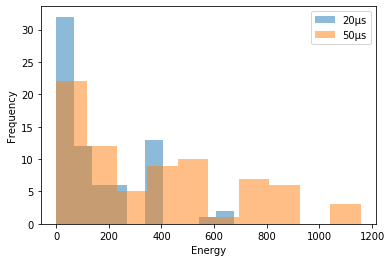

In [129]:
plt.hist([calcurate_energy(solution, vartype='SPIN') for solution in twenty_sol], alpha=0.5, label='20μs')
plt.hist([calcurate_energy(solution, vartype='SPIN') for solution in fifty_sol], alpha=0.5, label='50μs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

From the histogram above, we can see that the number of optimal solutions obtained decreased as the annealing time was increased, but we found more low energy solutions. However, it's not as simple as just increasing the annealing time. Sometimes the optimization works better when the annealing time is small. This dependency depends on each problem. In addition, quantum annealing and other annealing methods are meta-heuristic altorigthms. It is also important to note that each time you execute, the results you get will be different.

## Conclusion

Through the optimization of number division problem, we introduced D-Wave Ocean. We can do a lot of things just by holding on to what we've discussed in this tutorial. For example, we can investigate as follows.

- success probability (percentage of optimal solutions) relative to the number of readings, annealing time
- energy relative to the number of readings, annealing time
- the percentage of optimal solutions obtained relative to multiple optimal solutions.

As of April 2019, we can use the D-Wave machine for free for 1 minute per month. You should try.

D-Wave Leap: https://cloud.dwavesys.com/leap/

There are other annealing parameters that are not mentioned in this tutorial. For example, by specitying and annealing schedule, we can perform different techniques from normal annealing, such as reverse annealing.